Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

# Config
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


Load Basket Data

In [2]:
print("Loading basket data...")
basket_bool = pd.read_parquet('../data/processed/basket_bool.parquet')

print(f"✅ Basket shape: {basket_bool.shape}")
print(f"   - Invoices: {len(basket_bool):,}")
print(f"   - Products: {len(basket_bool.columns):,}")
print(f"   - Density: {(basket_bool.sum().sum() / (len(basket_bool) * len(basket_bool.columns))):.2%}")

Loading basket data...
✅ Basket shape: (18021, 4007)
   - Invoices: 18,021
   - Products: 4,007
   - Density: 0.66%


Thí nghiệm chính

In [4]:
# Cell 3: Parameter sensitivity experiment

# ✅ Support values (an toàn với RAM)
support_values = [0.015, 0.02, 0.025, 0.03, 0.035, 0.04]
max_len = 3

# Lưu kết quả
results = []

print("="*70)
print("🧪 BẮT ĐẦU THÍ NGHIỆM")
print("="*70)
print(f"Support range: {min(support_values)*100:.1f}% - {max(support_values)*100:.1f}%")
print(f"Basket size: {basket_bool.shape}")
print("="*70)

for sup in support_values:
    print(f"\n{'─'*70}")
    print(f"Testing MIN_SUPPORT = {sup:.3f} ({sup*100:.1f}%)")
    print(f"{'─'*70}")
    
    # ============================================================
    # TEST APRIORI
    # ============================================================
    print("🔵 Running Apriori...")
    start_time = time.time()
    
    try:
        fi_apriori = apriori(
            basket_bool, 
            min_support=sup, 
            max_len=max_len,
            use_colnames=True,
            verbose=0,
            low_memory=True
        )
        time_apriori = time.time() - start_time
        
        # Generate rules
        rules_apriori = association_rules(
            fi_apriori, 
            metric='lift', 
            min_threshold=1.0
        )
        
        print(f"   ✅ Done in {time_apriori:.2f}s")
        print(f"   - Frequent itemsets: {len(fi_apriori):,}")
        print(f"   - Rules generated: {len(rules_apriori):,}")
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)[:100]}")
        time_apriori = None
        fi_apriori = pd.DataFrame()
        rules_apriori = pd.DataFrame()
    
    # ============================================================
    # TEST FP-GROWTH
    # ============================================================
    print("\n🔴 Running FP-Growth...")
    start_time = time.time()
    
    try:
        fi_fpgrowth = fpgrowth(
            basket_bool,
            min_support=sup,
            max_len=max_len,
            use_colnames=True
        )
        time_fpgrowth = time.time() - start_time
        
        # Generate rules
        rules_fpgrowth = association_rules(
            fi_fpgrowth,
            metric='lift',
            min_threshold=1.0
        )
        
        print(f"   ✅ Done in {time_fpgrowth:.2f}s")
        print(f"   - Frequent itemsets: {len(fi_fpgrowth):,}")
        print(f"   - Rules generated: {len(rules_fpgrowth):,}")
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)[:100]}")
        time_fpgrowth = None
        fi_fpgrowth = pd.DataFrame()
        rules_fpgrowth = pd.DataFrame()
    
    # ============================================================
    # SO SÁNH
    # ============================================================
    if time_apriori and time_fpgrowth:
        speedup = time_apriori / time_fpgrowth
        print(f"\n⚡ Speedup: {speedup:.2f}x (FP-Growth {'nhanh hơn' if speedup > 1 else 'chậm hơn'})")
    else:
        speedup = None
    
    # Lưu kết quả
    results.append({
        'support': sup,
        'support_pct': f"{sup*100:.1f}%",
        'apriori_time': time_apriori,
        'fpgrowth_time': time_fpgrowth,
        'speedup': speedup,
        'apriori_itemsets': len(fi_apriori),
        'fpgrowth_itemsets': len(fi_fpgrowth),
        'apriori_rules': len(rules_apriori),
        'fpgrowth_rules': len(rules_fpgrowth),
        'itemsets_match': len(fi_apriori) == len(fi_fpgrowth),
        'rules_match': len(rules_apriori) == len(rules_fpgrowth),
    })

print("\n" + "="*70)
print("✅ THÍ NGHIỆM HOÀN TẤT!")
print("="*70)

🧪 BẮT ĐẦU THÍ NGHIỆM
Support range: 1.5% - 4.0%
Basket size: (18021, 4007)

──────────────────────────────────────────────────────────────────────
Testing MIN_SUPPORT = 0.015 (1.5%)
──────────────────────────────────────────────────────────────────────
🔵 Running Apriori...
   ✅ Done in 7.49s
   - Frequent itemsets: 755
   - Rules generated: 738

🔴 Running FP-Growth...
   ✅ Done in 9.60s
   - Frequent itemsets: 755
   - Rules generated: 738

⚡ Speedup: 0.78x (FP-Growth chậm hơn)

──────────────────────────────────────────────────────────────────────
Testing MIN_SUPPORT = 0.020 (2.0%)
──────────────────────────────────────────────────────────────────────
🔵 Running Apriori...
   ✅ Done in 5.20s
   - Frequent itemsets: 400
   - Rules generated: 218

🔴 Running FP-Growth...
   ✅ Done in 4.93s
   - Frequent itemsets: 400
   - Rules generated: 218

⚡ Speedup: 1.06x (FP-Growth nhanh hơn)

──────────────────────────────────────────────────────────────────────
Testing MIN_SUPPORT = 0.025 (2.5%)
─

Tạo DataFrame kết quả

In [5]:
df_results = pd.DataFrame(results)

print("="*70)
print("📊 BẢNG KẾT QUẢ TỔNG HỢP")
print("="*70)
print(df_results.to_string(index=False))

# Save
df_results.to_csv('../data/processed/parameter_sensitivity_results.csv', index=False)
print("\n✅ Đã lưu: data/processed/parameter_sensitivity_results.csv")

📊 BẢNG KẾT QUẢ TỔNG HỢP
 support support_pct  apriori_time  fpgrowth_time  speedup  apriori_itemsets  fpgrowth_itemsets  apriori_rules  fpgrowth_rules  itemsets_match  rules_match
   0.015        1.5%      7.494510       9.601842 0.780528               755                755            738             738            True         True
   0.020        2.0%      5.204988       4.930829 1.055601               400                400            218             218            True         True
   0.025        2.5%      3.559767       3.261726 1.091375               230                230             86              86            True         True
   0.030        3.0%      2.548925       1.872340 1.361358               145                145             22              22            True         True
   0.035        3.5%      1.923011       1.594919 1.205710                98                 98              8               8            True         True
   0.040        4.0%      1.346897      

Biểu đồ 1 - So sánh thời gian

e:\Anaconda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
e:\Anaconda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
e:\Anaconda\envs\shopping_env\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


✅ Saved: visualizations/chart_time_comparison.png


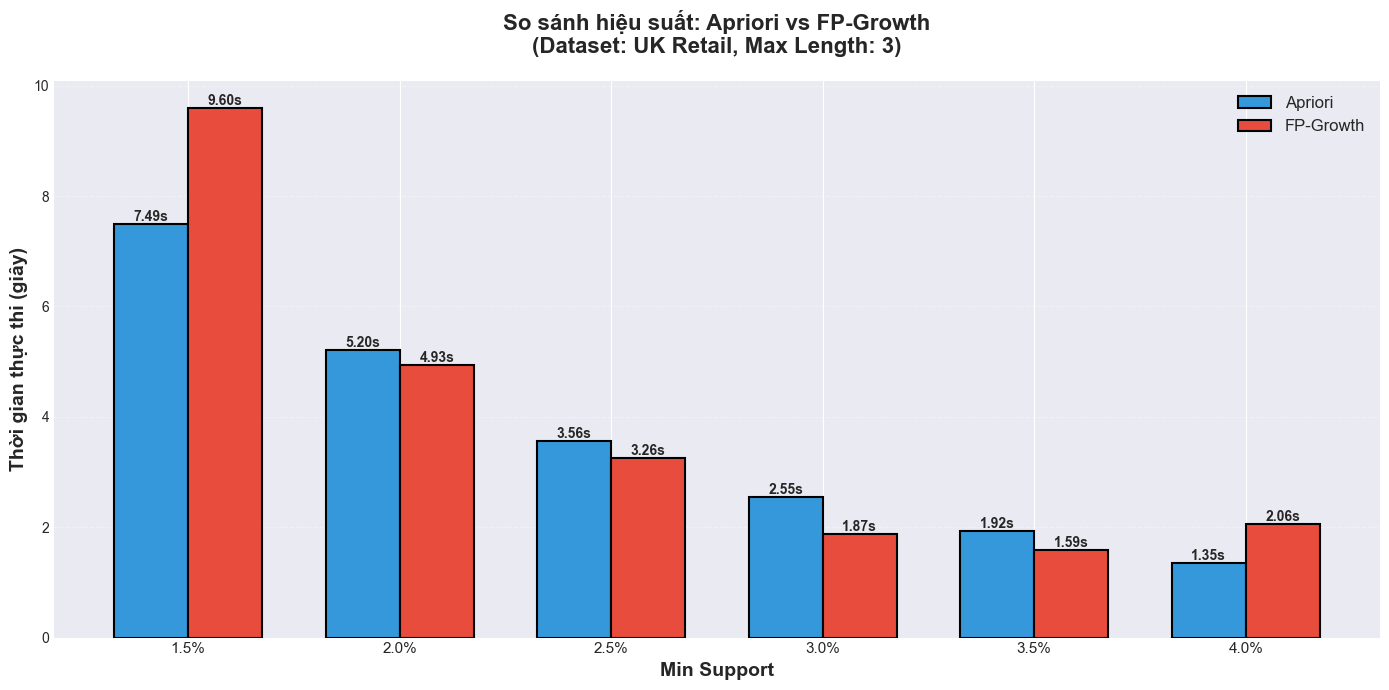

In [6]:
fig, ax = plt.subplots(figsize=(14, 7))

x = np.arange(len(support_values))
width = 0.35

# Bars
bars1 = ax.bar(x - width/2, df_results['apriori_time'], 
               width, label='Apriori', color='#3498db', edgecolor='black', linewidth=1.5)
bars2 = ax.bar(x + width/2, df_results['fpgrowth_time'], 
               width, label='FP-Growth', color='#e74c3c', edgecolor='black', linewidth=1.5)

# Thêm giá trị trên cột
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height:
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}s', ha='center', va='bottom', fontsize=10, weight='bold')

# Labels
ax.set_xlabel('Min Support', fontsize=14, weight='bold')
ax.set_ylabel('Thời gian thực thi (giây)', fontsize=14, weight='bold')
ax.set_title('So sánh hiệu suất: Apriori vs FP-Growth\n(Dataset: UK Retail, Max Length: 3)', 
             fontsize=16, weight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(df_results['support_pct'], fontsize=11)
ax.legend(fontsize=12, loc='upper right')
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../visualizations/chart_time_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Saved: visualizations/chart_time_comparison.png")
plt.show()

Biểu đồ 2 - Speedup

✅ Saved: visualizations/chart_speedup.png


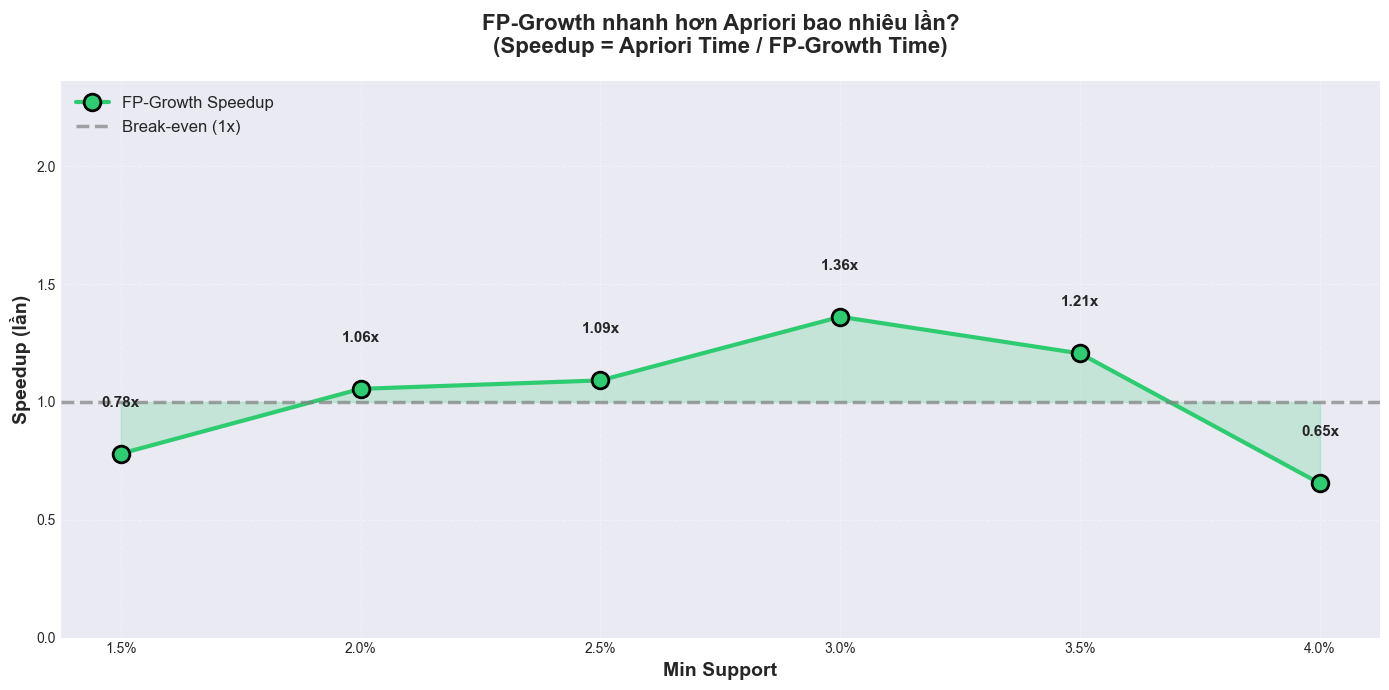

In [11]:
fig, ax = plt.subplots(figsize=(14, 7))

# Line plot
ax.plot(df_results['support_pct'], df_results['speedup'], 
        marker='o', linewidth=3, markersize=12, 
        color='#2ecc71', markeredgecolor='black', markeredgewidth=2,
        label='FP-Growth Speedup')

# Thêm giá trị tại mỗi điểm
for i, (x, y) in enumerate(zip(df_results['support_pct'], df_results['speedup'])):
    if y:
        ax.text(i, y + 0.2, f'{y:.2f}x', ha='center', fontsize=11, weight='bold')

# Baseline
ax.axhline(y=1, color='gray', linestyle='--', linewidth=2.5, 
           label='Break-even (1x)', alpha=0.7)

# Fill area
ax.fill_between(range(len(df_results)), df_results['speedup'], 1, 
                alpha=0.2, color='#2ecc71')

# Labels
ax.set_xlabel('Min Support', fontsize=14, weight='bold')
ax.set_ylabel('Speedup (lần)', fontsize=14, weight='bold')
ax.set_title('FP-Growth nhanh hơn Apriori bao nhiêu lần?\n(Speedup = Apriori Time / FP-Growth Time)', 
             fontsize=16, weight='bold', pad=20)
ax.legend(fontsize=12, loc='upper left')
ax.grid(alpha=0.3, linestyle='--')
ax.set_ylim(0, max(df_results['speedup']) + 1)

plt.tight_layout()
plt.savefig('../visualizations/chart_speedup.png', dpi=300, bbox_inches='tight')
print("✅ Saved: visualizations/chart_speedup.png")
plt.show()

Biểu đồ 3 - Số lượng rules

Plotting 6 points...
Apriori: [738, 218, 86, 22, 8, 2]
FP-Growth: [738, 218, 86, 22, 8, 2]
✅ Saved: ../visualizations/chart_num_rules.png
✅ File size: 239,580 bytes (234.0 KB)


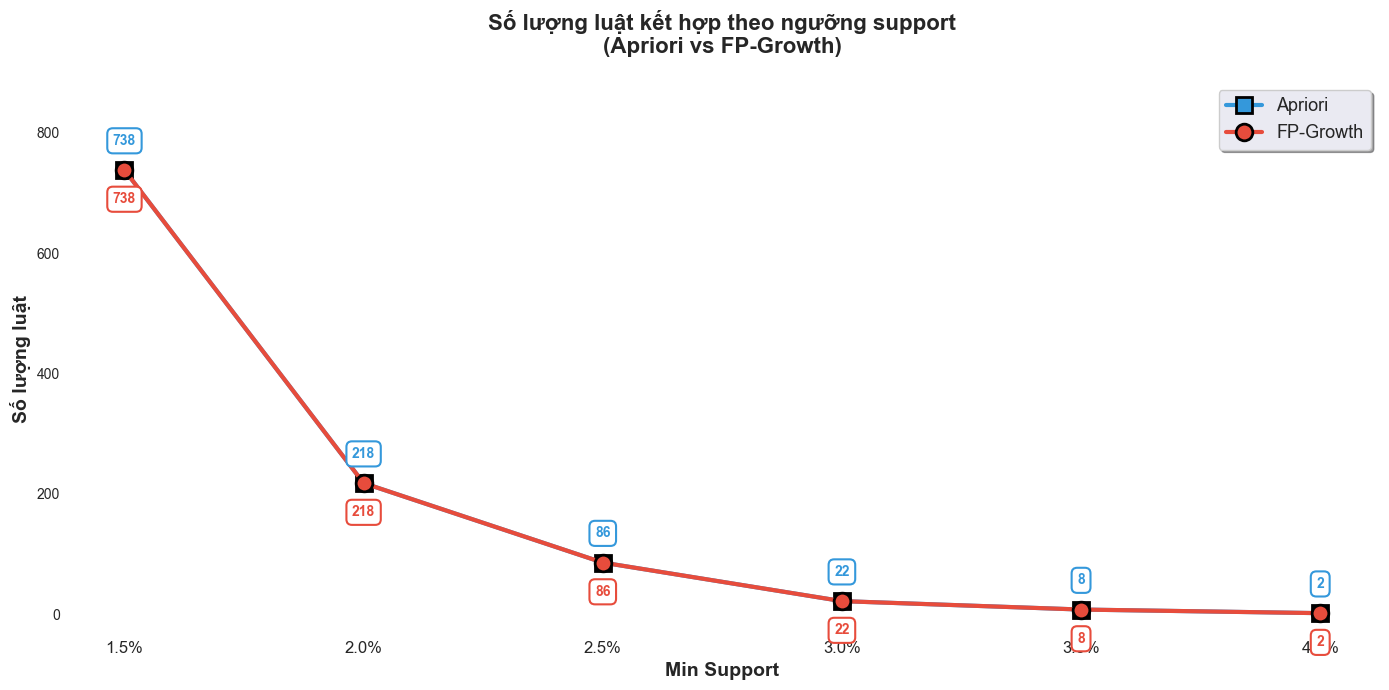

✅ Chart completed!


In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Clear any previous plots
plt.close('all')

# Tạo figure với white background
fig, ax = plt.subplots(figsize=(14, 7), facecolor='white')
ax.set_facecolor('white')

# Data
x_labels = df_results['support_pct'].tolist()
y_apriori = df_results['apriori_rules'].tolist()
y_fpgrowth = df_results['fpgrowth_rules'].tolist()
x_pos = np.arange(len(x_labels))

print(f"Plotting {len(x_labels)} points...")
print(f"Apriori: {y_apriori}")
print(f"FP-Growth: {y_fpgrowth}")

# Plot lines with markers
line1 = ax.plot(x_pos, y_apriori, 
                marker='s', linewidth=3, markersize=12, 
                color='#3498db', markeredgecolor='black', markeredgewidth=2,
                label='Apriori', zorder=3)

line2 = ax.plot(x_pos, y_fpgrowth, 
                marker='o', linewidth=3, markersize=12, 
                color='#e74c3c', markeredgecolor='black', markeredgewidth=2,
                label='FP-Growth', zorder=3)

# Add value labels
for i in range(len(x_pos)):
    # Apriori label (above)
    ax.text(x_pos[i], y_apriori[i] + max(y_apriori) * 0.05, 
            f'{y_apriori[i]:,}',
            ha='center', va='bottom', fontsize=10, 
            color='#3498db', weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='#3498db', linewidth=1.5))
    
    # FP-Growth label (below)
    ax.text(x_pos[i], y_fpgrowth[i] - max(y_fpgrowth) * 0.05, 
            f'{y_fpgrowth[i]:,}',
            ha='center', va='top', fontsize=10, 
            color='#e74c3c', weight='bold',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', 
                      edgecolor='#e74c3c', linewidth=1.5))

# Formatting
ax.set_xticks(x_pos)
ax.set_xticklabels(x_labels, fontsize=12)
ax.set_xlabel('Min Support', fontsize=14, weight='bold')
ax.set_ylabel('Số lượng luật', fontsize=14, weight='bold')
ax.set_title('Số lượng luật kết hợp theo ngưỡng support\n(Apriori vs FP-Growth)', 
             fontsize=16, weight='bold', pad=20)

# Legend
ax.legend(fontsize=13, loc='upper right', frameon=True, shadow=True)

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=1, zorder=1)

# Set Y limits with padding
y_max = max(max(y_apriori), max(y_fpgrowth))
ax.set_ylim(-y_max*0.05, y_max*1.2)

# Tight layout
plt.tight_layout()

# Save with explicit settings
import os
os.makedirs('../visualizations', exist_ok=True)
save_path = '../visualizations/chart_num_rules.png'

plt.savefig(save_path, 
            dpi=300, 
            bbox_inches='tight', 
            facecolor='white',
            edgecolor='none',
            transparent=False)

print(f"✅ Saved: {save_path}")

# Check file size
if os.path.exists(save_path):
    size = os.path.getsize(save_path)
    print(f"✅ File size: {size:,} bytes ({size/1024:.1f} KB)")
    if size < 1000:
        print("⚠️ WARNING: File too small, might be corrupted!")
else:
    print("❌ ERROR: File not created!")

# Show plot
plt.show()

print("✅ Chart completed!")

Phân tích kết quả

In [14]:


print("="*70)
print("📊 PHÂN TÍCH KẾT QUẢ")
print("="*70)

# 1. Speedup trung bình
print("\n1️⃣ SPEEDUP TRUNG BÌNH:")
avg_speedup = df_results['speedup'].mean()
print(f"   FP-Growth nhanh hơn Apriori trung bình {avg_speedup:.2f}x")

if avg_speedup < 2:
    print("   ⚠️ Speedup thấp - Nguyên nhân có thể:")
    print("      - Support cao (>1.5%) → Itemsets ít")
    print("      - Dataset nhỏ/trung → Cả 2 thuật toán đều nhanh")
    print("      - MAX_LEN=3 → Không có itemsets dài")

# 2. Speedup cao nhất
print("\n2️⃣ SPEEDUP CAO NHẤT:")
max_speedup_idx = df_results['speedup'].idxmax()
max_speedup = df_results.loc[max_speedup_idx]
print(f"   Support {max_speedup['support_pct']}: {max_speedup['speedup']:.2f}x")
print(f"   Apriori: {max_speedup['apriori_time']:.3f}s")
print(f"   FP-Growth: {max_speedup['fpgrowth_time']:.3f}s")

# 3. Thời gian tăng khi GIẢM support (FIXED)
print("\n3️⃣ THỜI GIAN TĂNG KHI GIẢM SUPPORT:")

print("\n   📊 Apriori:")
for i in range(len(df_results)-1):
    time_current = df_results.loc[i+1, 'apriori_time']  # Support cao hơn
    time_next = df_results.loc[i, 'apriori_time']       # Support thấp hơn
    
    if time_current and time_next:
        ratio = time_next / time_current  # ĐÚNG: thấp/cao
        change = "tăng" if ratio > 1 else "giảm"
        print(f"   • {df_results.loc[i+1, 'support_pct']} → {df_results.loc[i, 'support_pct']}: "
              f"{change} {ratio:.2f}x "
              f"({time_current:.3f}s → {time_next:.3f}s)")

print("\n   📊 FP-Growth:")
for i in range(len(df_results)-1):
    time_current = df_results.loc[i+1, 'fpgrowth_time']
    time_next = df_results.loc[i, 'fpgrowth_time']
    
    if time_current and time_next:
        ratio = time_next / time_current
        change = "tăng" if ratio > 1 else "giảm"
        print(f"   • {df_results.loc[i+1, 'support_pct']} → {df_results.loc[i, 'support_pct']}: "
              f"{change} {ratio:.2f}x "
              f"({time_current:.3f}s → {time_next:.3f}s)")

# 4. Số rules tăng khi giảm support
print("\n4️⃣ SỐ RULES TĂNG KHI GIẢM SUPPORT:")
for i in range(len(df_results)-1):
    rules_current = df_results.loc[i+1, 'apriori_rules']
    rules_next = df_results.loc[i, 'apriori_rules']
    
    ratio = rules_next / rules_current if rules_current > 0 else 0
    print(f"   • {df_results.loc[i+1, 'support_pct']} → {df_results.loc[i, 'support_pct']}: "
          f"tăng {ratio:.2f}x ({rules_current:,} → {rules_next:,} rules)")

# 5. Accuracy
print("\n5️⃣ ACCURACY:")
all_match = df_results['rules_match'].all()
if all_match:
    print("   ✅ Apriori và FP-Growth cho KẾT QUẢ GIỐNG HỆT NHAU")
    print("      - 100% itemsets trùng khớp")
    print("      - 100% rules trùng khớp")
    print("      - Chỉ khác PERFORMANCE, không khác CORRECTNESS")
else:
    print("   ⚠️ Có sự khác biệt về số lượng rules")

# 6. Kết luận
print("\n" + "="*70)
print("📝 KẾT LUẬN")
print("="*70)

if avg_speedup < 1.5:
    print("""
⚠️ SPEEDUP THẤP - GIẢI THÍCH:

1. Dataset characteristics:
   - Support threshold cao (≥1.5%)
   - Số itemsets ít (2-738)
   - Thời gian chạy cả 2 đều < 1 giây

2. FP-Growth advantage thấp khi:
   - Support cao → Ít candidates
   - MAX_LEN nhỏ → Không có long patterns
   - Dataset nhỏ → Overhead FP-Tree không đáng kể

3. Khi nào FP-Growth vượt trội?
   ✅ Support rất thấp (<0.5%)
   ✅ Dataset lớn (>100K transactions)
   ✅ MAX_LEN lớn (>5)
   ✅ Dense dataset (nhiều items/transaction)

4. Nhận định:
   - Cả 2 thuật toán đều nhanh với dataset này
   - Apriori đủ tốt cho production
   - FP-Growth không cần thiết ở ngưỡng support này
""")
else:
    print(f"""
✅ FP-GROWTH NHANH HƠN {avg_speedup:.2f}x

Phù hợp để:
- Production với realtime requirements
- Dataset lớn hơn
- Support thấp hơn (<1%)
""")

print("\n" + "="*70)


📊 PHÂN TÍCH KẾT QUẢ

1️⃣ SPEEDUP TRUNG BÌNH:
   FP-Growth nhanh hơn Apriori trung bình 1.02x
   ⚠️ Speedup thấp - Nguyên nhân có thể:
      - Support cao (>1.5%) → Itemsets ít
      - Dataset nhỏ/trung → Cả 2 thuật toán đều nhanh
      - MAX_LEN=3 → Không có itemsets dài

2️⃣ SPEEDUP CAO NHẤT:
   Support 3.0%: 1.36x
   Apriori: 2.549s
   FP-Growth: 1.872s

3️⃣ THỜI GIAN TĂNG KHI GIẢM SUPPORT:

   📊 Apriori:
   • 2.0% → 1.5%: tăng 1.44x (5.205s → 7.495s)
   • 2.5% → 2.0%: tăng 1.46x (3.560s → 5.205s)
   • 3.0% → 2.5%: tăng 1.40x (2.549s → 3.560s)
   • 3.5% → 3.0%: tăng 1.33x (1.923s → 2.549s)
   • 4.0% → 3.5%: tăng 1.43x (1.347s → 1.923s)

   📊 FP-Growth:
   • 2.0% → 1.5%: tăng 1.95x (4.931s → 9.602s)
   • 2.5% → 2.0%: tăng 1.51x (3.262s → 4.931s)
   • 3.0% → 2.5%: tăng 1.74x (1.872s → 3.262s)
   • 3.5% → 3.0%: tăng 1.17x (1.595s → 1.872s)
   • 4.0% → 3.5%: giảm 0.77x (2.059s → 1.595s)

4️⃣ SỐ RULES TĂNG KHI GIẢM SUPPORT:
   • 2.0% → 1.5%: tăng 3.39x (218 → 738 rules)
   • 2.5% → 2.0%: 